<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/GoldStandard/golds_thyroid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install tensorflow==2.7.0
#!pip install scikeras

# Subclassing for GS

In [16]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q

    
 
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        # p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        # temp1 = ann_*tf.math.log(p_logreg)  
        # temp2 = (1 - ann_)*tf.math.log(1/K)*tf.reduce_sum(Y_true,axis=1)
        # aux = tf.repeat(tf.reduce_sum(pred*tf.math.log(pred),axis=1,keepdims=True), R, axis = 1)
        # tf.print(tf.shape(aux))
        # print(tf.shape(aux))
        # temp2 = (1 - ann_)*aux*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        # Y_true_1 = tf.clip_by_value(Y_true, clip_value_min=1e-9, clip_value_max=1)
        # p_logreg_inv = tf.math.reduce_prod(tf.math.pow(Y_true_1, Y_hat), axis=1)
        # temp2 = (1 - ann_)*tf.math.log(p_logreg_inv) 
        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X.shape[1]), name='entrada')
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*2*(self.K)),activation='selu',name='h1',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
        h2 = tf.keras.layers.Dense(int(P*(self.K)),activation='selu',name='h2',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
       #capa de salida
        output = tf.keras.layers.Dense(self.K,activation="softmax",name='output',
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt,metrics=['accuracy'])
         
            
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split,   #
                                      batch_size=self.batch_size,verbose=self.verbose)
 
        return self
            
      
  
    
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q
                }

  
        return self


In [3]:
#cargar datos desde drive acceso libre
#https://drive.google.com/file/d/1maFFCChk-0l98cHSMJx3ljCOig41midA/view?usp=sharing
FILEID = "1maFFCChk-0l98cHSMJx3ljCOig41midA"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O new-thyroid.zip && rm -rf /tmp/cookies.txt
!unzip -o new-thyroid.zip
!dir

--2023-02-03 06:02:51--  https://docs.google.com/uc?export=download&confirm=&id=1maFFCChk-0l98cHSMJx3ljCOig41midA
Resolving docs.google.com (docs.google.com)... 108.177.11.102, 108.177.11.101, 108.177.11.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.11.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tolu0jge8ker0drn3gr3h2q61g5n8jjm/1675404150000/07591141114418430227/*/1maFFCChk-0l98cHSMJx3ljCOig41midA?e=download&uuid=e241ec4a-e0d0-4995-948c-0ad177a5192a [following]
--2023-02-03 06:02:51--  https://doc-14-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tolu0jge8ker0drn3gr3h2q61g5n8jjm/1675404150000/07591141114418430227/*/1maFFCChk-0l98cHSMJx3ljCOig41midA?e=download&uuid=e241ec4a-e0d0-4995-948c-0ad177a5192a
Resolving doc-14-90-docs.googleusercontent.com (doc-14-90-docs.googleusercontent.com)... 74.125.31.132, 26

# Load Data

In [4]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
database = 'thyroid' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']



import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv(r'/content/new-thyroid.csv') 
df.head()

#Dividing X and y
t = np.array(LabelEncoder().fit_transform(df['class'].tolist()))
X = np.array(df.drop(['class'], axis = 1).values)
print('X',X.shape,'t',t.shape)

X (215, 5) t (215,)


In [5]:
 
t

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Split data

In [6]:
import numpy.matlib
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3,random_state =123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test = X[train_index,:], X[test_index,:] 
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape,  Y_true_train.shape)

[167 200  31 128  93 158 165 133 190 139 119  19 107 187  20 122 198 186
 193  52 204  71 166 178   4 201  79 197 116 161 172  21 127  53 179  72
 206 149  10  42  81  26  11 140  90 150 120  85 183 100  88 143 189  37
  50  62 108  77 181  24 175 169  33  23 194]
(150, 5) (150, 1)


In [7]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
 
clf = LogisticRegression(random_state=0).fit(X_train, Y_true_train.ravel())
 
clf.score(X_test, Y_true_test.ravel())

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9846153846153847

# Apply MinMaxScaler

In [8]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Testing the Class 


iteration: 0


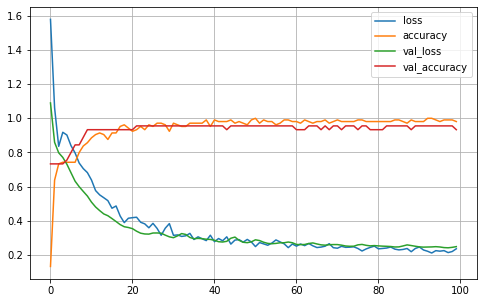

3/3 [==============================] - 0s 4ms/step
Validation ACC: 0.9538
Validation Balanced_ACC: 0.9074
Validation MI: 0.7341
Validation Normalized MI: 0.7954
Validation Adjusted MI: 0.7874
Validation aUc: 0.9530
iteration: 1


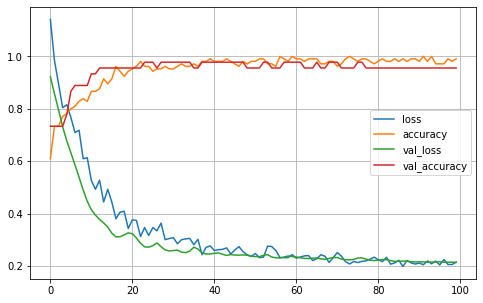

3/3 [==============================] - 0s 5ms/step
Validation ACC: 0.9692
Validation Balanced_ACC: 0.9490
Validation MI: 0.8064
Validation Normalized MI: 0.8647
Validation Adjusted MI: 0.8595
Validation aUc: 0.9735
iteration: 2


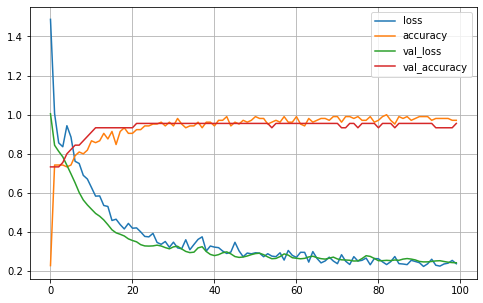

3/3 [==============================] - 0s 4ms/step
Validation ACC: 0.9692
Validation Balanced_ACC: 0.9490
Validation MI: 0.8064
Validation Normalized MI: 0.8647
Validation Adjusted MI: 0.8595
Validation aUc: 0.9735
iteration: 3


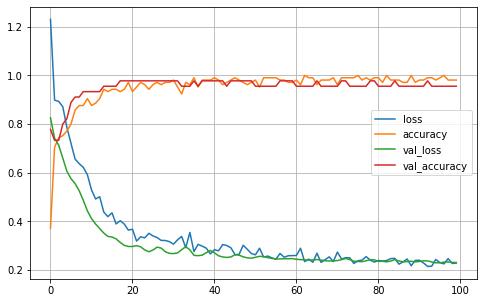

3/3 [==============================] - 0s 5ms/step
Validation ACC: 0.9692
Validation Balanced_ACC: 0.9490
Validation MI: 0.8064
Validation Normalized MI: 0.8647
Validation Adjusted MI: 0.8595
Validation aUc: 0.9735
iteration: 4


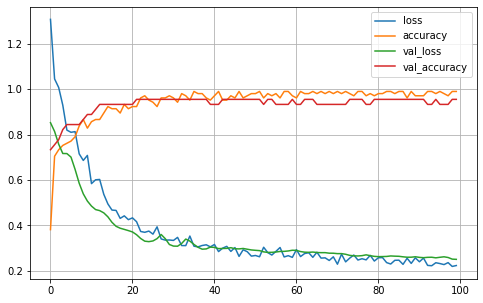

3/3 [==============================] - 0s 3ms/step
Validation ACC: 0.9692
Validation Balanced_ACC: 0.9199
Validation MI: 0.7875
Validation Normalized MI: 0.8620
Validation Adjusted MI: 0.8565
Validation aUc: 0.9600
iteration: 5


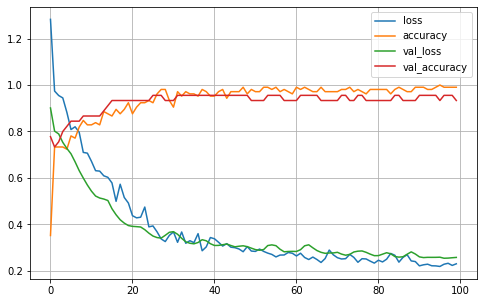

3/3 [==============================] - 0s 3ms/step
Validation ACC: 0.9538
Validation Balanced_ACC: 0.9074
Validation MI: 0.7341
Validation Normalized MI: 0.7954
Validation Adjusted MI: 0.7874
Validation aUc: 0.9530
iteration: 6


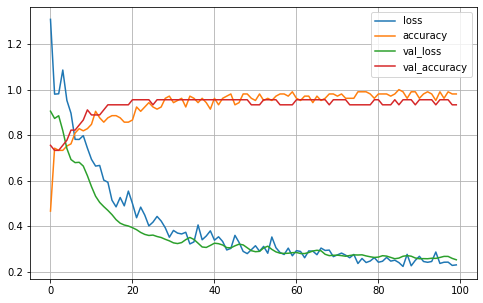

3/3 [==============================] - 0s 4ms/step
Validation ACC: 0.9538
Validation Balanced_ACC: 0.9074
Validation MI: 0.7341
Validation Normalized MI: 0.7954
Validation Adjusted MI: 0.7874
Validation aUc: 0.9530
iteration: 7


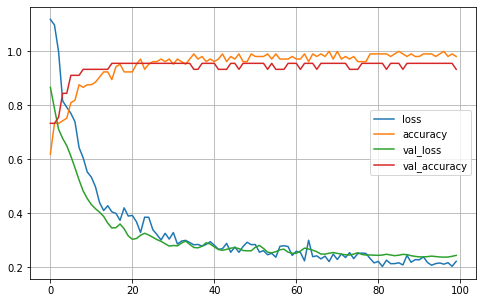

3/3 [==============================] - 0s 4ms/step
Validation ACC: 0.9538
Validation Balanced_ACC: 0.9074
Validation MI: 0.7341
Validation Normalized MI: 0.7954
Validation Adjusted MI: 0.7874
Validation aUc: 0.9530
iteration: 8


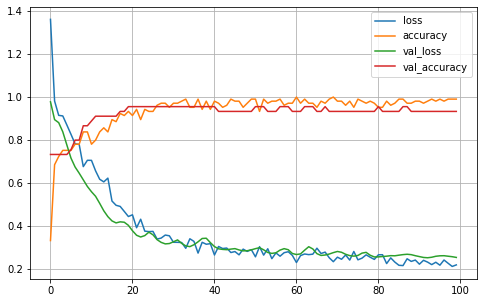

3/3 [==============================] - 0s 3ms/step
Validation ACC: 0.9538
Validation Balanced_ACC: 0.9074
Validation MI: 0.7341
Validation Normalized MI: 0.7954
Validation Adjusted MI: 0.7874
Validation aUc: 0.9530
iteration: 9


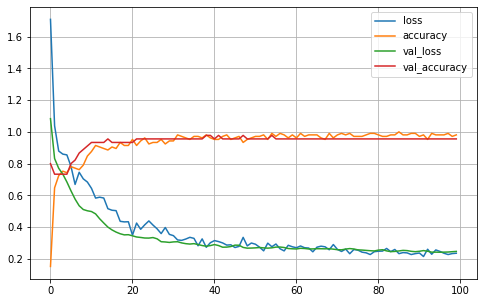

3/3 [==============================] - 0s 2ms/step
Validation ACC: 0.9692
Validation Balanced_ACC: 0.9458
Validation MI: 0.8052
Validation Normalized MI: 0.8646
Validation Adjusted MI: 0.8594
Validation aUc: 0.9730


In [27]:
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
l1 =0.001
NUM_RUNS =10
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
   
    MA = Keras_MA_GCCE(epochs=100,batch_size=64,R=5, K=len(np.unique(Y_true_train)), dropout=0.5, learning_rate=0.01,optimizer='Adam', 
                l1_param=l1,  validation_split=0.30, verbose=0, q=0.1)

    
    MA.fit(X_train,  Y_true_train)
    MA.plot_history()
  
    #Accuracy
    pred_2 = MA.predict(X_test)
 
    report = classification_report( pred_2.argmax(axis=1),Y_true_test.ravel(),output_dict=True)
    ACC[i] = report['accuracy']
    print("Validation ACC: %.4f" % (float(ACC[i])))


    # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


    #AUC
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
   # val_logits =MA.predict(X_test) # model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test, pred_2.argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation aUc: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    

In [10]:

# from sklearn.metrics import classification_report
# l1 =   0.001
# NUM_RUNS =10
# ACC = np.zeros(NUM_RUNS)
# AUC = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS): #10
#     print("iteration: " + str(i))
#     MA = Keras_MA_GCCE(epochs=100,batch_size=64,R=5, K=len(np.unique(Y_true_train)), dropout=0.5, learning_rate=0.01,optimizer='Adam', 
#                 l1_param=l1,  validation_split=0.30, verbose=0, q=0.1)


#     MA.fit(X_train, Y_true_train)
#     MA.plot_history()
  
#     #Accuracy
#     pred_2 = MA.predict(X_test)
 
#     report = classification_report( Y_true_test.ravel(), pred_2.argmax(axis=1), output_dict=True)
#     ACC[i] = report['accuracy']
#     print("ACC: %.4f" % (float(report['accuracy']),))
#     #AUC
#     val_AUC_metric = tf.keras.metrics.AUC(num_thresholds=3, from_logits = True)  
#     val_logits =MA.predict(X_test) # model(X_test, training=False)
#     # tf.print(y_batch_val)
#     val_AUC_metric.update_state(Y_true_test.ravel(), val_logits.argmax(axis=1).astype('float'))

#     val_AUC = val_AUC_metric.result()
#     val_AUC_metric.reset_states()
#     val_AUC = val_AUC.numpy()
#     print("Validation aUc: %.4f" % (float(val_AUC),))
#     AUC[i] = val_AUC

In [20]:
ACC

array([0.93846154, 0.95384615, 0.95384615, 0.95384615, 0.93846154,
       0.93846154, 0.83076923, 0.86153846, 0.95384615, 0.95384615])

In [28]:

AUC

array([0.95300007, 0.97350007, 0.97350007, 0.97350007, 0.96000004,
       0.95300007, 0.95300007, 0.95300007, 0.95300007, 0.97300005])

In [29]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)

Average Accuracy:  96.15
Average std:  0.77


In [30]:
print('Average Accuracy: ', np.round( AUC.mean(),4)*100) 
print('Average std: ',np.round(np.std( AUC),4)*100)

Average Accuracy:  96.19
Average std:  0.96


In [31]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  96.15
Average std:  0.77
Average AUC:  96.19
Average AUC std:  0.96
Average Balanced Accuracy:  92.5
Average std:  1.94
Average MI:  76.82
Average std:  3.46
Average Normalized MI:  82.98
Average std:  3.44
Average Ajdusted MI:  82.31
Average std:  3.5700000000000003
